In [2]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import dask
from time import sleep
import seaborn as sns
import itertools

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# Activate package autoload.
%load_ext autoreload
%autoreload 2

## Summarizing what I've learned

The size of the mask makes a huge difference in computational time, and it looks like there are diminished returns over a mask of about 20x200x200:

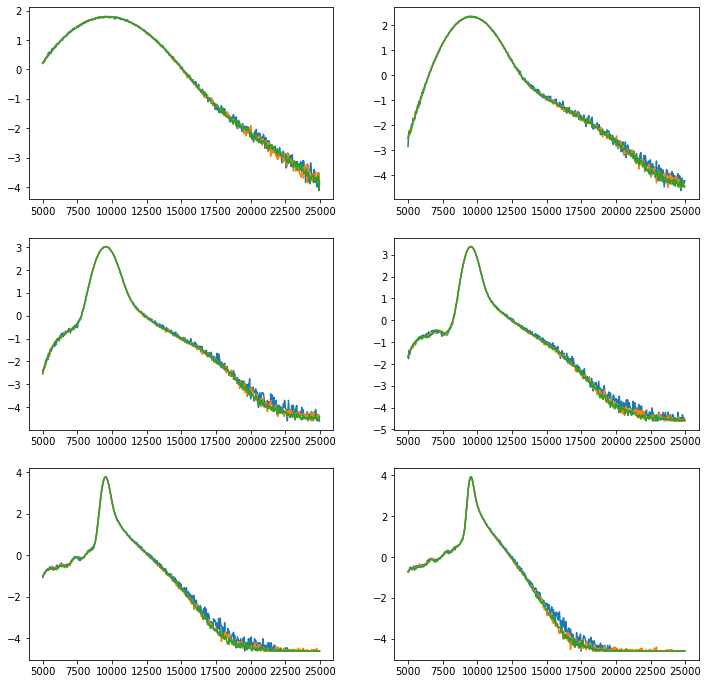

In [3]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
axes = np.ravel(ax)
sizes=[
    #[20, 100, 100],
    [20, 200, 200],
    [20, 300, 300],
    [20, 400, 400]
    #[40, 300, 300],
]
for n in range(0, len(sizes)):
    mask = fm.make_dummy_mask(zdim=sizes[n][0], idim=sizes[n][1], jdim=sizes[n][2], nuc_spacing=100, nuc_rad=50)
    sim = fm.simulate_blobs(mask, bg_mean=9500, bg_var=2600, blob_intensity_mean=12_000, 
        blob_intensity_var=1000, blob_radius_mean=2, blob_radius_var=0.5, blob_number=100, 
        z_ij_ratio=2)
    ssh = fm.make_scalespace_2dhist(sim, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=500, histrange=(5000, 25_000))
    ssh = np.apply_along_axis(lambda x: x / np.sum(x), 1, ssh) * 1000 # Normalize rows to sum to 1.
    ssh = np.log(ssh + 0.01)
    for i in range(0, 6):
        axes[i].plot(np.arange(5000,25_000, 20_000/500), ssh[i])

With this mask, I did ~95,000 simulations in 2.5 hours using dask parallization on savio3 (40 cores). Pretty good. 

Mask size has some other important features: Because the blob number is done on a per-nucleus basis, partial nuclei create a problem. Mask sizes need to be chosen such that all nuclei are complete. For the same reason, changing the number of Z slices will change the profile. The data we get out ultimately needs to be normalized on a "number or spots per nuclear volume" basis. 

The next issues are comparison. I want to test out using the logs of the histograms.

In [322]:
simdata = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/sims1-4.pkl')[0]
test = simdata[100][1].copy()

In [98]:
def params_sortnorm(x):
    """Sort based on last column, normalize all other columns."""
    x_normsort = x[np.argsort(x[:,-1])]
    for i in range(0, x.shape[1] - 1):
        min_ = np.min(x_normsort[:,i])
        max_ = np.max(x_normsort[:,i])
        x_normsort[:,i] = ((x_normsort[:,i] - min_) / (max_ - min_))
    return x_normsort

def histcomp(hist_in, simdata, histcomp_func, sort=True):
    """Compare 2d histograms, make ndarray with simulation parameters and comparison score tacked on."""
    params_plus_comp = np.zeros((0, len(simdata[0][0]) + 1))
    for i in range(0, len(simdata)):
        comp_value = histcomp_func(hist_in.flatten(), simdata[i][1].flatten())
        this_params_plus_comp = simdata[i][0] + [comp_value]
        params_plus_comp = np.vstack([params_plus_comp, this_params_plus_comp])
    
    if sort:
        return params_sortnorm(params_plus_comp)
    return(params_plus_comp)


In [324]:
def hist2d_normlog(histdata):
    normlogged = copy.deepcopy(histdata)
    for n in range(0, len(histdata)):
        normlogged_hist = np.apply_along_axis(lambda x: x / np.sum(x) * 1e4, 1, histdata[n][1])
        normlogged_hist = np.log(normlogged_hist + 0.1)    
        normlogged[n] = tuple([histdata[n][0], normlogged_hist])
    return normlogged

simdata_nl = hist2d_normlog(simdata)   

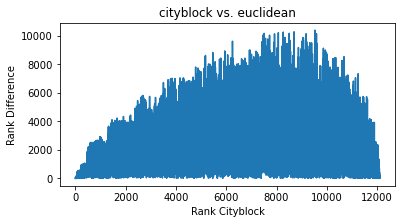

In [327]:
# Rank disagreement of distance metrics
test = simdata_nl[1000][1]

fig, ax = plt.subplots(1,1, figsize=(6,3))
axes = np.ravel(ax)

funcs = [scipy.spatial.distance.cityblock, scipy.spatial.distance.euclidean]
names = ['cityblock', 'euclidean', 'sqeuclidean']
plotnum=0
for n in range(0, len(funcs)-1):
    for m in range(1, len(funcs)):
        #if (n != m):
            
        data1 = histcomp(test, simdata_nl, funcs[n], sort=False)
        data2 = histcomp(test, simdata_nl, funcs[m], sort=False)
        rankdif = abs(np.argsort(data1[:,-1]) - np.argsort(data2[:,-1]))
        axes[plotnum].plot(rankdif)
        axes[plotnum].set_title(names[n]+' vs. ' + names[m])
        axes[plotnum].set_xlabel('Rank Cityblock')
        axes[plotnum].set_ylabel('Rank Difference')
        plotnum += 1

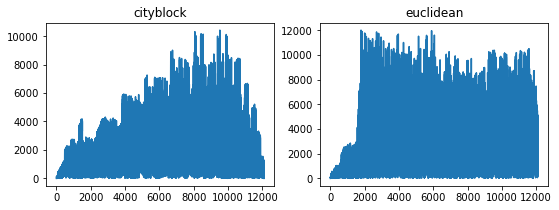

In [63]:
# Rank disagreement for normlogged vs. not normlogged
n = 1000
test1 = simdata_nl[n][1]
test2 = simdata[n][1]

fig, ax = plt.subplots(1,2, figsize=(9,3))
axes = np.ravel(ax)

funcs = scipy.spatial.distance.cityblock, scipy.spatial.distance.euclidean
names = ['cityblock', 'euclidean']
plotnum=0
for j in range(0,2):        
    data1 = histcomp(test1, simdata_nl, funcs[j], sort=False)
    data2 = histcomp(test2, simdata, funcs[j], sort=False)
    rankdif = abs(np.argsort(data1[:,-1]) - np.argsort(data2[:,-1]))
    axes[j].plot(rankdif)
    axes[j].set_title(names[j])

This is a pretty pleasing result. The use of cityblock vs manhattan and logged vs. unlogged data is clearly significant, but is greatly reduced for the highest-scoring comparisons. This means that the conclusions will probably be pretty stable regardless of the choices made for these. That's nice.

Some tasks now:

- Prepare real data (mask HLBs) for comparison

- Figure out how to think about/look at results.

I'll start with the second point. It would be nice to visualize the results, i.e. the best-scoring models. I've 

In [104]:
def params_plot_heat(data, n=100, names=['bg_mean', 'bg_var', 'blob_intensity_mean', 'blob_intensity_var', 'blob_radius_mean', 'blob_radius_var', 'blob_number']):
    df = pd.DataFrame(data[:,:-1], columns=names)
    sns.heatmap(df.iloc[:n,:])


In [521]:
# Load bigger dataset with 95k simulations.
simdata = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/sims1-3-1.pkl')[0]  

In [523]:
simdata_nl = hist2d_normlog(simdata)

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_67591/1764576787.py:7: RuntimeWarning: invalid value encountered in true_divide
  x_normsort[:,i] = ((x_normsort[:,i] - min_) / (max_ - min_))


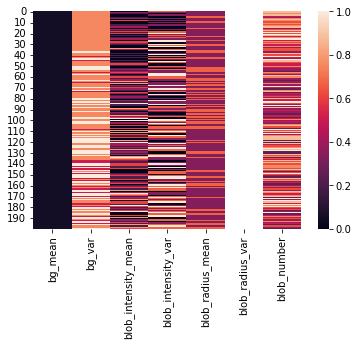

In [251]:
test = simdata_nl[7000][1]
#data1 = histcomp(test, simdata_nl, scipy.spatial.distance.euclidean, sort=True)
params_plot_heat(data1, 200)

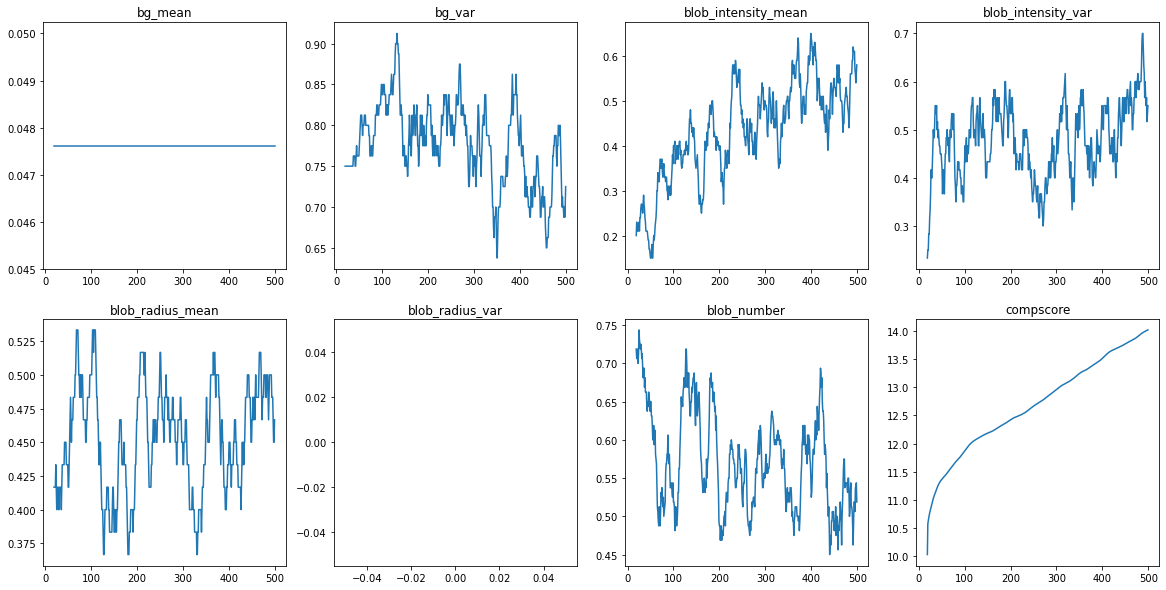

In [124]:
def plot_params(data, names=['bg_mean', 'bg_var', 'blob_intensity_mean', 'blob_intensity_var', 'blob_radius_mean', 'blob_radius_var', 'blob_number', 'compscore']):
    fig, ax = plt.subplots(2,4, figsize=(20,10))
    axes = np.ravel(ax)
    df = pd.DataFrame(data, columns=names)
    for j in range(0,8):
        #axes[n].plot(c.iloc[:,n].rolling(20).mean())
        #axes[n].set_title(c.columns[n])
        axes[j].plot(df[names[j]].rolling(20).mean()[:500])
        axes[j].set_title(df.columns[j])
plot_params(data1)


In [126]:
print(data1[0,:])

[0.04761905 0.75       0.         0.66666667 0.33333333        nan
 0.875      0.        ]


In [127]:
print(data1[1,:])

[0.04761905 0.75       0.4        0.33333333 0.33333333        nan
 0.875      9.75636263]


Re-simulate the data with a ton of sigmas, put weights on each sigma, learn weights to make parameters match.

Make a table: rows are sims, columns are difference scores for sigmas.



In [269]:
def histcomp2(params_in, hist_in, simdata, histcomp_func, sort=True):
    """Compare 2d histograms separately for each sigma level."""
    def norm_(x):
        x1 = x.copy()
        for i in range(0, x.shape[1]):
            x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])
        return x1
    num_sigmas = simdata[0][1].shape[0]
    params = np.zeros((0, len(simdata[0][0])))
    hist_diff_scores = np.zeros((0, num_sigmas))
    for i in range(0, len(simdata)):
        hist_diff = []
        for j in range(0, num_sigmas):
            comp_value = histcomp_func(hist_in[j], simdata[i][1][j])
            hist_diff.append(comp_value)

        hist_diff_scores = np.vstack([hist_diff_scores, hist_diff])   
        params = np.vstack([params, simdata[i][0]])

    return(norm_(hist_diff_scores), norm_(params))

hist_diff, params = histcomp2(simdata_nl[0][0], simdata_nl[0][1], simdata_nl, scipy.spatial.distance.euclidean)    

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_67591/1837070221.py:6: RuntimeWarning: invalid value encountered in true_divide
  x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])


In [222]:
def params_subtract(params, ref_params):
    params_sub = np.zeros(params.shape[0])
    for i in range(0, params.shape[0]):
        params_sub[i] = np.nansum(np.square(params[i, :] - ref_params))
    return params_sub

In [235]:
params_sub = params_subtract(params, params[0])

In [238]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(hist_diff, params_sub)

1. How to determine similarity of images? What is the smart way to compare scale-space histograms (or other representation)?

    - test comparison function -> do comparison to all sims -> assess degree to which top-scoring sims match parameters

- Take subset of sims

- write scoring function (similarity of parameters in top n models). Take weights, calc scores, sort, calc similarity of top n models.

- Fit weights.

1. How to determine similarity of images? What is the smart way to compare scale-space histograms (or other representation)?

    - test comparison function -> do comparison to all sims -> assess degree to which top-scoring sims match parameters

2. Once I have a list of top-scoring simulations, what do I do with this?

I think it would be nice to reduce variables. Can I measure the mean and SD of the background? The size of the blobs?

In [313]:
def compare_2dhists_params(simdata, n, histcomp_func, sort=True):
    """Compare 2d histograms separately for each sigma level."""
    def norm_columns(x):
        """Normalize columns to mean=0 SD=1."""
        x1 = x.copy()
        for i in range(0, x.shape[1]):
            x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])
        return x1

    def params_distance(params, ref_params):
        """Compute euclidean distance of each parameter set to reference 
        set of parameters."""
        params_sub = np.zeros(params.shape[0])
        for i in range(0, params.shape[0]):
            params_sub[i] = np.nansum(np.square(params[i, :] - ref_params))
        return params_sub

    ref_hist = simdata[n][1]

    num_sigmas = simdata[0][1].shape[0]
    params = np.zeros((0, len(simdata[0][0])))
    hist_diff_scores = np.zeros((0, num_sigmas))

    # Calculate histogram differentials for each sigma, stack corresponding 
    # parameters into array.
    for i in range(0, len(simdata)):
        hist_diff = []
        for j in range(0, num_sigmas):
            comp_value = histcomp_func(ref_hist[j], simdata[i][1][j])
            hist_diff.append(comp_value)

        hist_diff_scores = np.vstack([hist_diff_scores, hist_diff])   
        params = np.vstack([params, simdata[i][0]])
    
    hist_diff_scores_normed = norm_columns(hist_diff_scores)
    params_normed = norm_columns(params)
    ref_params = params_normed[n]
    params_distances = params_distance(params_normed, ref_params)

    return(hist_diff_scores_normed, params_distances)

simdata_test = random.sample(simdata_nl, 2000)
hist_diff2, param_dist2 = compare_2dhists_params(simdata_test, 0, scipy.spatial.distance.euclidean)

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_67591/1183432064.py:7: RuntimeWarning: invalid value encountered in true_divide
  x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])


In [357]:
def cost_func(hist_distances_list, param_distances_list, weights, n):
    cost = 0
    for i in range(0, len(hist_distances_list)):
        hist_distances = hist_distances_list[i]
        param_distances = param_distances_list[i]
        if len(weights) != hist_distances.shape[1]:
            raise ValueError('Wrong number of weights')
        weighted_sum = np.sum(hist_distances * weights, axis=1)
        param_distances_sorted = param_distances[np.argsort(weighted_sum)]
        cost += np.sum(param_distances_sorted[:n])
    return cost

In [567]:
# Do hist and param comparison for a number of random sims.
simdata_ = random.sample(simdata_nl, 50000)
#simdata_ = simdata_nl
hist_diffs = []
param_dists = []
for n in range(0, 10):
    refnum = random.randint(0, len(simdata_))
    hist_diff, param_dist = compare_2dhists_params(simdata_, refnum, scipy.spatial.distance.euclidean)
    hist_diffs.append(hist_diff)
    param_dists.append(param_dist)


/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_67591/1183432064.py:7: RuntimeWarning: invalid value encountered in true_divide
  x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])


KeyboardInterrupt: 

In [566]:
# Do hist and param comparison for a number of random sims.
simdata_ = random.sample(simdata_nl, 50000)
#simdata_ = simdata_nl
hist_diffs = []
param_dists = []
b_delayed = []
for n in range(0, 10):
    refnum = random.randint(0, len(simdata_))
    a = dask.delayed(compare_2dhists_params)(simdata_, refnum, scipy.spatial.distance.euclidean)
    b_delayed.append(a)
    #hist_diffs.append(hist_diff)
    #param_dists.append(param_dist)


In [570]:
b = dask.compute(b_delayed)

KeyboardInterrupt: 

/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/ipykernel_67591/1183432064.py:7: RuntimeWarning: invalid value encountered in true_divide
  x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])


In [549]:
cost_func_wrapped = lambda x: cost_func(hist_diffs, param_dists, x, 100)

In [555]:
simdata_nl[0][1].shape

(7, 650)

In [550]:
minimizer_kwargs = {'bounds': ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))}
niter=1000
T=1000
#optimize.basinhopping(cost_func_wrapped, [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], niter=niter, T=T, minimizer_kwargs=minimizer_kwargs)
weights = np.zeros((0,8))
for n in range(0, 10):
    res = optimize.differential_evolution(cost_func_wrapped, bounds=((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)), maxiter=100)
    weights = np.vstack((weights, np.concatenate((res['x'], [res['fun']]))))

fm.viewer(weights * 100, 4)

interactive(children=(Dropdown(description='Color', index=5, options=('Reds', 'prism', 'inferno', 'viridis', '…

In [551]:
fm.viewer(weights[:,:7] * 100, 4)

interactive(children=(Dropdown(description='Color', index=5, options=('Reds', 'prism', 'inferno', 'viridis', '…

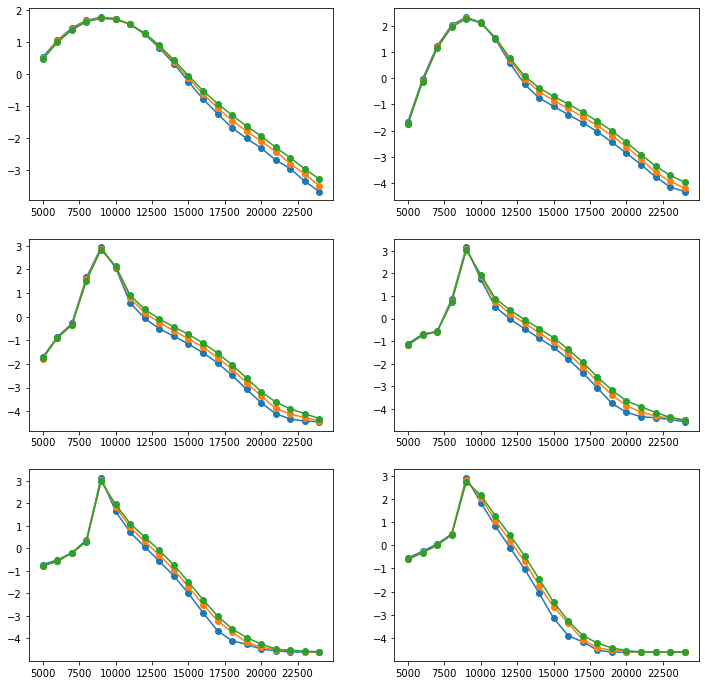

In [627]:
def rebin(arr, new_shape):
    arr = np.expand_dims(arr, axis=0)
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)[0]

fig, ax = plt.subplots(3,2, figsize=(12,12))
axes = np.ravel(ax)
sizes=[
    #[20, 100, 100],
    [20, 200, 200],
    [20, 300, 300],
    [20, 400, 400]
    #[40, 300, 300],
]
for n in range(0, len(sizes)):
    mask = fm.make_dummy_mask(zdim=sizes[n][0], idim=sizes[n][1], jdim=sizes[n][2], nuc_spacing=100, nuc_rad=50)
    sim = fm.simulate_blobs(mask, bg_mean=9500, bg_var=2600, blob_intensity_mean=12_000, 
        blob_intensity_var=1000, blob_radius_mean=2, blob_radius_var=0.5, blob_number=int(100 * ((0.25 * n)+1)), 
        z_ij_ratio=2)
    ssh = fm.make_scalespace_2dhist(sim, [0.25, 0.5, 0.75,1.0,1.5, 2], mask, numbins=500, histrange=(5000, 25_000))
    ssh = np.apply_along_axis(lambda x: x / np.sum(x), 1, ssh) * 1000 # Normalize rows to sum to 1.
    ssh = np.log(ssh + 0.01)
    for i in range(0, 6):
        #axes[i].plot(np.arange(5000,25_000, 20_000/500), ssh[i])
        numbins = 20
        axes[i].plot(np.arange(5000,25_000, 20_000/numbins), rebin(ssh[i], [1,numbins]), marker="o")


In [3]:
mask = fm.make_dummy_mask(20, 200,200, 100)

In [27]:

bg_mean_range=[9000, 9500, 10_000]
bg_var_range=[2500, 3000, 3500]
blob_intensity_mean_range=[25_000, 30_000, 35_000]
blob_intensity_var_range=[8000, 10000, 12_000]
blob_radius_mean_range=[0.5, 1, 1.5]
blob_radius_var_range=[0.25, 0.5, 0.75]
blob_number_range=[50, 100, 150]
%time
data_delayed = fm.make_parameter_hist_data(bg_mean_range, bg_var_range, blob_intensity_mean_range, 
    blob_intensity_var_range, blob_radius_mean_range, blob_radius_var_range, 
    blob_number_range, sigmas=[0.5, 1, 1.5, 2, 2.5, 3], zdim=20, idim=200, jdim=200, nuc_spacing=100,
    numbins=100, histrange=(0,65_000))

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [28]:
data = dask.compute(data_delayed)

In [71]:
fm.save_pickle(data, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/histograms_forML.pkl')

In [2]:
data = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/histograms_forML.pkl')

In [12]:
def prepare_hist_param_data(data, num_hist_bins=100):
    """Process data output from blob simulator (list of tuples, 
    0 is params, 1 is 2d histogram) for feeding to ML function. 
    
    For histograms: 
        - Bin (if desired)
        - Normalize each 1d histogram by dividing by sum (-> probabilities)
        - Flatten
        - Take log (after adding a bit to avoid 0)

    For parameters:
        - Combine into single 2d numpy array (rows are entries)
        - Normalize each column (mean 0 sd 1)
    
         """
    
    def rebin(a, shape):
        sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
        return a.reshape(sh).mean(-1).mean(1)

    def norm_columns(x):
        """Normalize columns to mean=0 SD=1."""
        x1 = x.copy()
        for i in range(0, x.shape[1]):
            x1[:,i] = (x[:,i] - np.mean(x[:,i])) / np.std(x[:,i])
        return x1

    num_sigmas = data[0][1].shape[0]
    num_params = len(data[0][0])
    num_entries = len(data)
    histograms_processed = np.zeros((num_entries, num_sigmas * num_hist_bins))
    params = np.zeros((num_entries, num_params))

    for i in range(num_entries):
        params[i] = data[i][0]
        hist2d = data[i][1].copy()
        # Bin histograms.
        hist2d = rebin(hist2d, [hist2d.shape[0], num_hist_bins])
        # Normalize by dividing by row sum.
        hist2d = np.apply_along_axis(lambda x: x / np.sum(x), axis=1, arr=hist2d)
        # Flatten.
        hist_flattened = hist2d.flatten()
        # Add small number to account for 0s, take log, assign.
        zero_pad = np.min(hist_flattened[hist_flattened > 0]) / 100
        hist_flatlog = np.log(hist_flattened + zero_pad)
        histograms_processed[i] = hist_flatlog

    params = norm_columns(params)    
    return histograms_processed, params

histograms, params = prepare_hist_param_data(data)

In [16]:
fm.save_pickle((histograms, params), '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/processed_data_forML.pkl')

In [15]:
p = np.random.permutation(10)
histograms[[1,4,5]]

array([[-17.94127626, -17.94127626, -13.32615575, ..., -17.94127626,
        -17.94127626, -17.94127626],
       [-17.94127626, -17.94127626, -12.63797136, ..., -17.94127626,
        -17.94127626, -17.94127626],
       [-17.94127626, -17.94127626, -17.94127626, ..., -17.94127626,
        -17.94127626, -17.94127626]])

In [105]:
def difference_hist_params(histograms, params, dist_func=scipy.spatial.distance.euclidean):
    num_entries = histograms.shape[0]
    hist_diffs = np.zeros((num_entries * num_entries, histograms.shape[1]))
    param_diffs = np.zeros(num_entries * num_entries)
    for i in range(num_entries):
        start = i * num_entries
        hist_diffs[start : (start + num_entries)] = histograms - histograms[i]
        # Get parameter distances.
        param_diffs[start : (start + num_entries)] = np.apply_along_axis(lambda x: dist_func(x, params[i]), axis=1, arr=params)

    return hist_diffs, param_diffs
   

In [106]:
hist_diffs, param_diffs = difference_hist_params(histograms, params)